In [3]:
import statistics as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import math
from keras.regularizers import l1, l2
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from collections import Counter
from scipy.signal import find_peaks
import collections

In [9]:
FF_df = pd.read_csv('form_factors.csv')
TD_x_df = pd.read_csv('gpr_total_density_x_200.csv')
TD_y_df = pd.read_csv('gpr_total_density_y_200.csv')

FF_df = FF_df.transpose()
TD_x_df = TD_x_df.transpose()
TD_y_df = TD_y_df.transpose()

In [10]:
names = []
for index in FF_df.columns:
    names.append(str(index) + 'i')
    names.append(str(index) + 'v')

FF_peak_df = pd.DataFrame(index=range(23), columns=names)
TD_peak_df = pd.DataFrame(index=range(41), columns=names)

FF_largest_amount = 0
TD_largest_amount = 0

for index in FF_df.columns:
    max_peaks_FF, _ = find_peaks(FF_df[index])
    min_peaks_FF, _ = find_peaks(-FF_df[index])
    
    FF_peak_index = np.hstack((max_peaks_FF, min_peaks_FF))
    FF_peak_index.sort()
    FF_peak_value = FF_df[index][FF_peak_index]
    
    if FF_largest_amount < len(FF_peak_index):
        FF_largest_amount = len(FF_peak_index)
    
    FF_peak_df[str(index) + 'i'] = pd.Series(FF_peak_index)
    FF_peak_df[str(index) + 'v'] = pd.Series(list(FF_peak_value))
    
    max_peaks_TD, _ = find_peaks(TD_y_df[index])
    min_peaks_TD, _ = find_peaks(-TD_y_df[index])
    
    TD_peak_index = np.hstack((max_peaks_TD, min_peaks_TD))
    TD_peak_index.sort()
    TD_peak_value = TD_y_df[index][TD_peak_index]
    
    if TD_largest_amount < len(TD_peak_index):
        TD_largest_amount = len(TD_peak_index)
    
    TD_peak_df[str(index) + 'i'] = pd.Series(TD_peak_index)
    TD_peak_df[str(index) + 'v'] = pd.Series(list(TD_peak_value))
    
print(FF_largest_amount)
print(TD_largest_amount)

C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3622603169.py:37: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  TD_peak_df[str(index) + 'v'] = pd.Series(list(TD_peak_value))


23
41


In [11]:
n_nans = FF_peak_df.isna().sum(axis=0)
FF_peak_amounts = FF_peak_df.isna().sum(axis=0).value_counts().values
i = 0 
wanted_amount = round(613*0.9,1)
amount = 0
sample_nans = []
for nan_amount in FF_peak_df.isna().sum(axis=0).value_counts().index:
    if amount < wanted_amount:
        sample_nans.append(nan_amount)
        amount = amount + FF_peak_amounts[i]/2
    i = i + 1
    
common_peak_filtered_FF = pd.DataFrame()

common_peak_FF_columns = set()
n_nans = FF_peak_df.isna().sum(axis=0)
highest_nans = 0
for nans in sample_nans:
    col_names = n_nans[n_nans == nans].index
    FF_peak_filtered = FF_peak_df[col_names]
    
    for column in FF_peak_filtered.columns:
        common_peak_FF_columns.add(column[:-1])
        common_peak_filtered_FF[column] = FF_peak_filtered[column]

common_peak_FF_columns = list(common_peak_FF_columns)

C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3543605176.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  common_peak_filtered_FF[column] = FF_peak_filtered[column]
C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3543605176.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  common_peak_filtered_FF[column] = FF_peak_filtered[column]
C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3543605176.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3543605176.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  common_peak_filtered_FF[column] = FF_peak_filtered[column]
C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3543605176.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  common_peak_filtered_FF[column] = FF_peak_filtered[column]
C:\Users\niila\AppData\Local\Temp\ipykernel_25492\3543605176.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, wh

In [12]:
random.seed(42)
removed_cases = random.sample(common_peak_FF_columns,int(amount-wanted_amount))
sample_simulations = []
for column in common_peak_FF_columns:
    if str(column) in removed_cases:
       continue
    sample_simulations.append(int(column))

peak_samples = []
for sample in sample_simulations:
    peak_samples.append(str(sample) + 'i')
    peak_samples.append(str(sample) + 'v')

In [13]:
sample_simulations.sort()
Common_double_point_peak_FF = common_peak_filtered_FF[peak_samples]
Common_peak_FF_df = FF_df[sample_simulations]
Common_peak_TD_x_df = TD_x_df[sample_simulations]
Common_peak_TD_y_df = TD_y_df[sample_simulations]

In [14]:
for i in Common_peak_TD_y_df.columns:
    Common_peak_TD_y_df[i] = Common_peak_TD_y_df[i]-round((Common_peak_TD_y_df[i][0]+Common_peak_TD_y_df[i][199])/2,3)

C:\Users\niila\AppData\Local\Temp\ipykernel_25492\2436385403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Common_peak_TD_y_df[i] = Common_peak_TD_y_df[i]-round((Common_peak_TD_y_df[i][0]+Common_peak_TD_y_df[i][199])/2,3)


Plots of different TD peak cases for FF of 13 minimums and maximums
TD peak cases of min and max sums: [5, 7, 8, 9, 6, 11, 10, 4, 3, 12, 15, 14, 13, 16, 27, 20, 21, 17, 18, 31]
TD peak case freqs: [29.0, 29.0, 22.0, 20.0, 18.0, 18.0, 16.0, 11.0, 9.0, 6.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0]


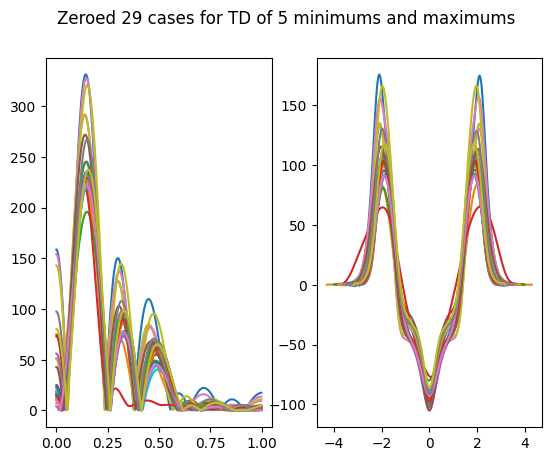

Indexes: [0, 257, 132, 390, 135, 395, 15, 402, 23, 536, 548, 41, 300, 175, 53, 182, 437, 572, 444, 68, 581, 201, 205, 80, 100, 239, 245, 501, 127]


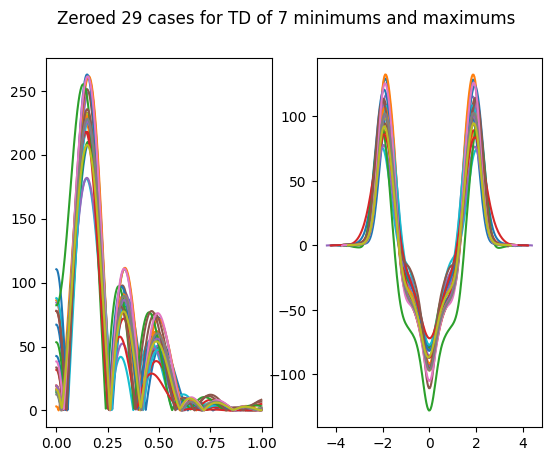

Indexes: [128, 262, 409, 28, 413, 158, 287, 44, 172, 564, 54, 317, 578, 584, 457, 206, 467, 344, 218, 91, 92, 475, 477, 611, 228, 488, 365, 117, 248]


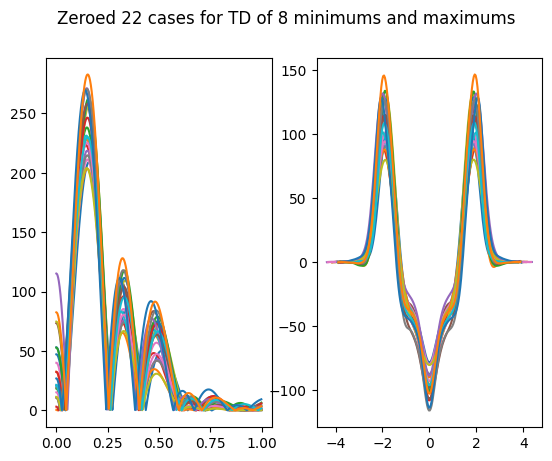

Indexes: [136, 144, 275, 153, 549, 166, 295, 422, 424, 47, 449, 456, 463, 471, 88, 217, 605, 352, 354, 361, 116, 509]


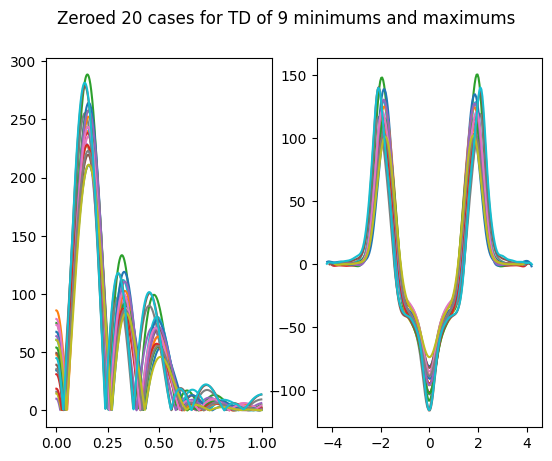

Indexes: [389, 268, 270, 527, 401, 29, 36, 294, 178, 439, 567, 568, 67, 580, 452, 74, 479, 481, 493, 115]


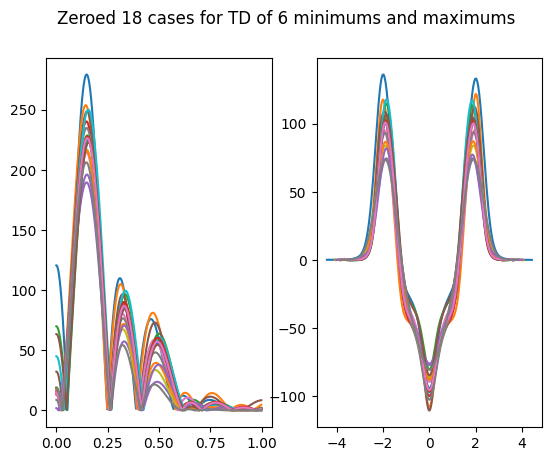

Indexes: [608, 35, 227, 69, 122, 7, 106, 490, 428, 141, 526, 174, 240, 17, 22, 278, 538, 125]


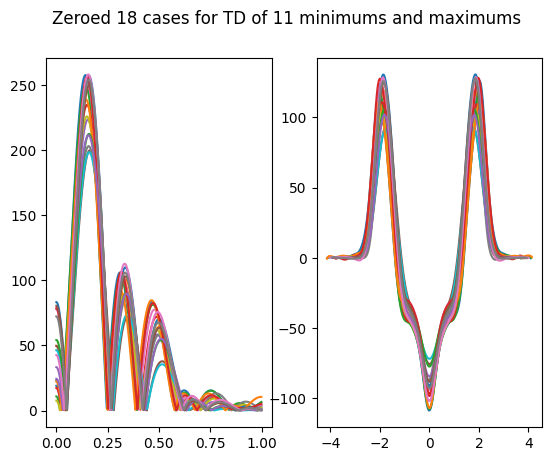

Indexes: [544, 577, 325, 38, 357, 504, 267, 427, 557, 491, 367, 464, 495, 84, 184, 157, 574, 351]


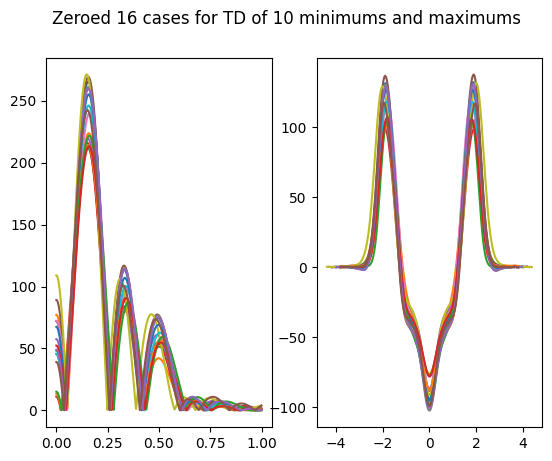

Indexes: [2, 516, 70, 358, 40, 328, 203, 366, 79, 21, 309, 282, 315, 189, 94, 63]


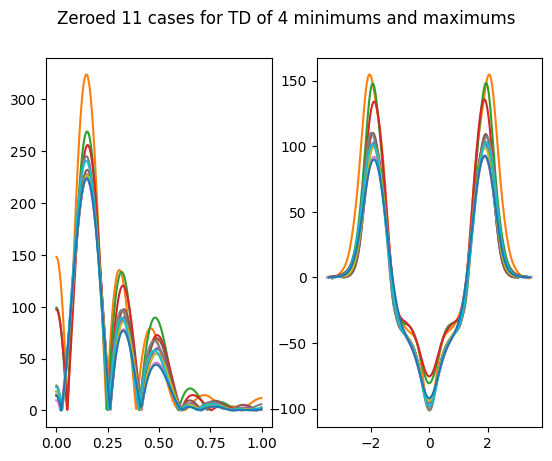

Indexes: [291, 134, 425, 11, 429, 562, 244, 181, 90, 285, 191]


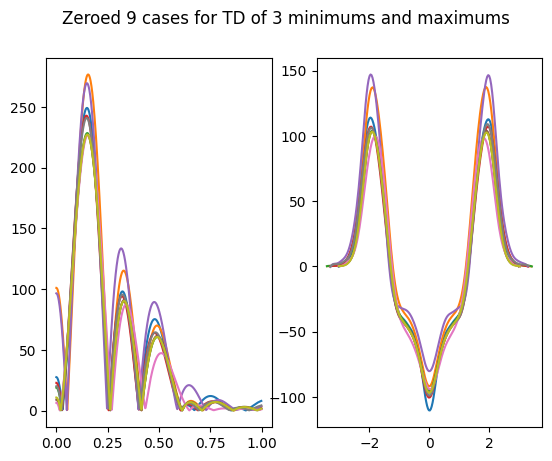

Indexes: [324, 102, 552, 264, 331, 591, 120, 186, 318]


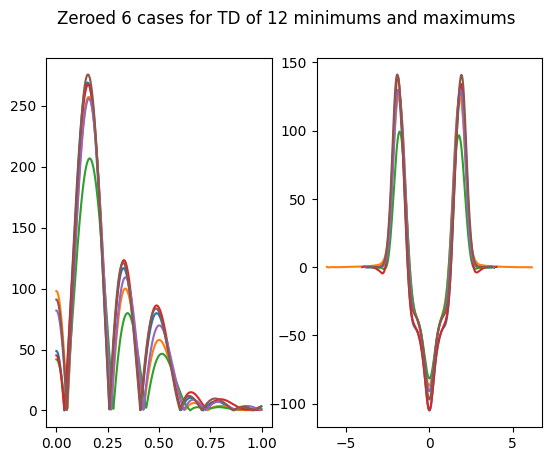

Indexes: [225, 386, 3, 237, 81, 310]


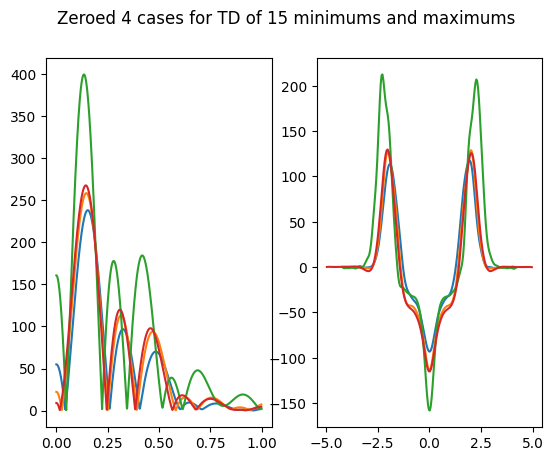

Indexes: [329, 124, 533, 575]


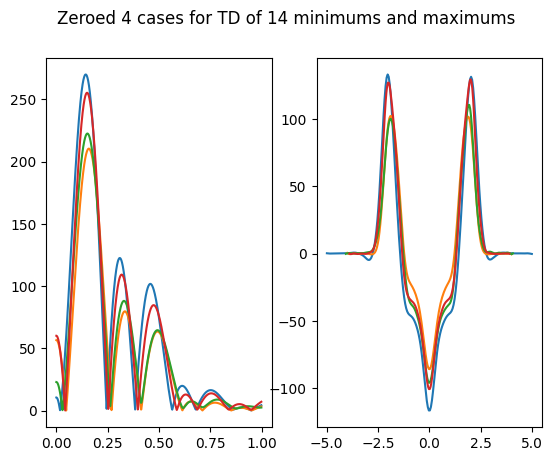

Indexes: [320, 161, 610, 151]


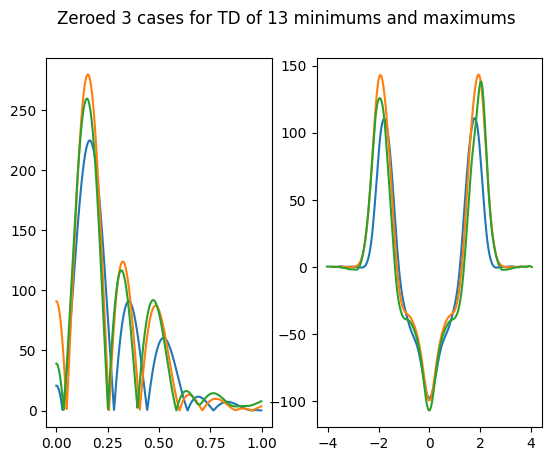

Indexes: [342, 148, 62]


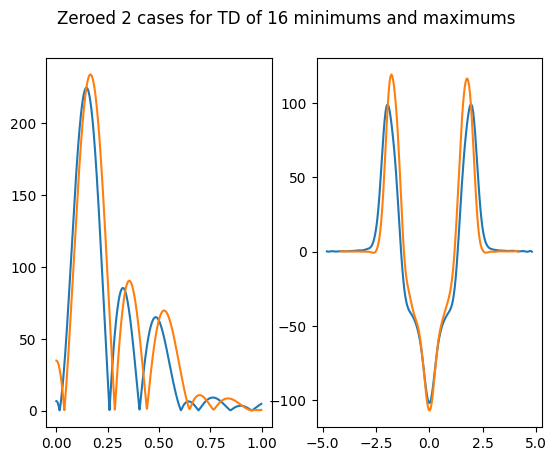

Indexes: [531, 470]


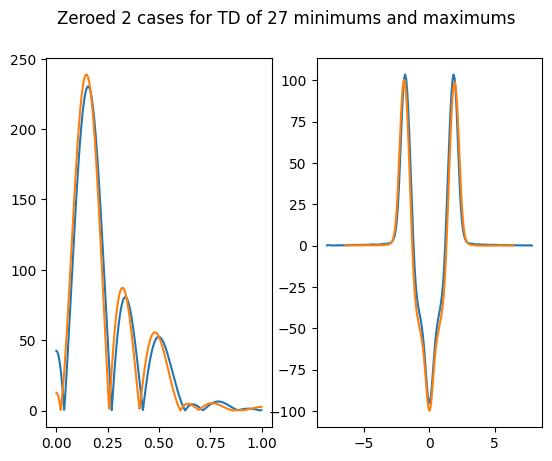

Indexes: [587, 52]


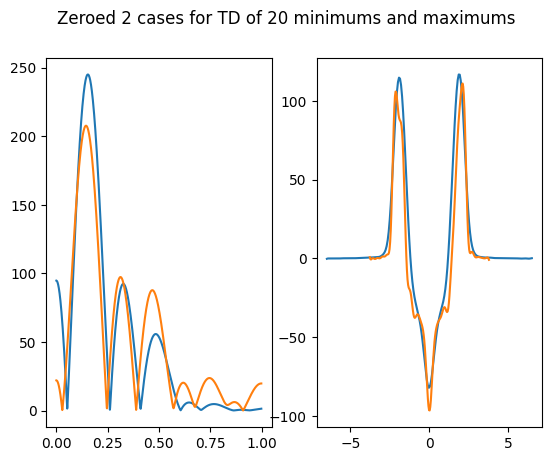

Indexes: [585, 105]


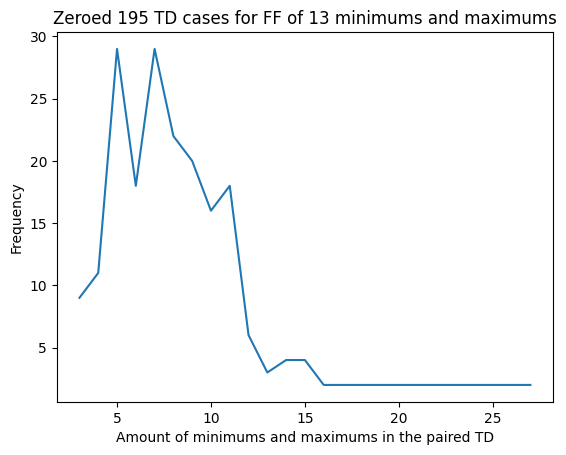


Plots of different TD peak cases for FF of 12 minimums and maximums
TD peak cases of min and max sums: [7, 9, 8, 11, 13, 5, 4, 6, 10, 12, 31, 19, 25, 3, 17, 15, 16, 14, 30, 26, 18, 20, 28, 22, 27]
TD peak case freqs: [19.0, 17.0, 16.0, 15.0, 15.0, 15.0, 12.0, 11.0, 9.0, 9.0, 7.0, 7.0, 5.0, 5.0, 4.0, 4.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]


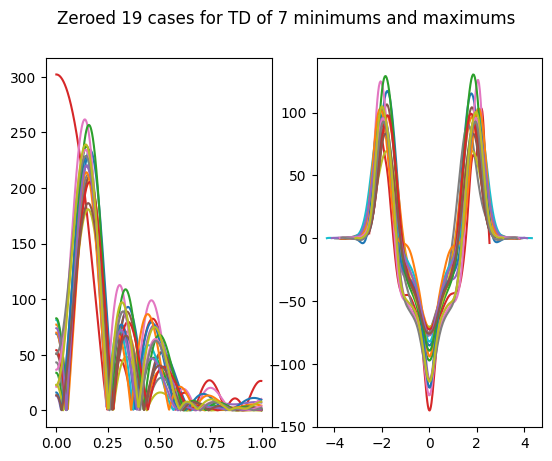

Indexes: [9, 537, 542, 32, 170, 304, 441, 571, 446, 447, 192, 190, 72, 335, 214, 224, 494, 249, 255]


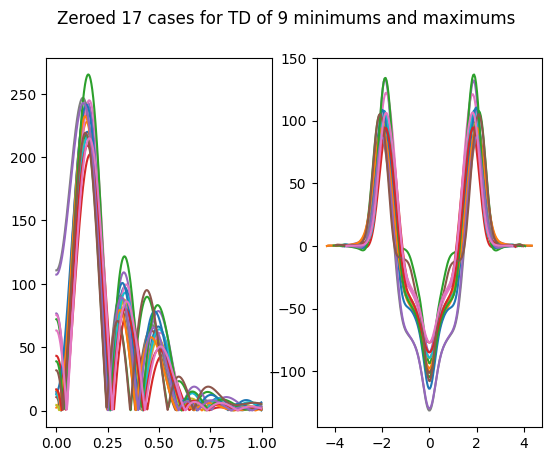

Indexes: [322, 450, 420, 485, 167, 296, 73, 75, 76, 332, 85, 472, 377, 26, 219, 220, 414]


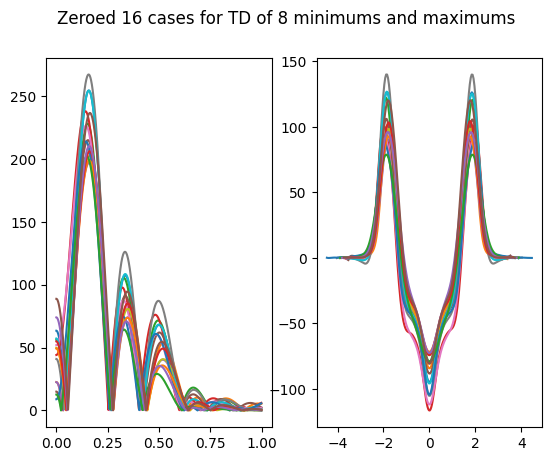

Indexes: [512, 289, 260, 6, 232, 137, 202, 398, 496, 177, 500, 150, 343, 312, 349, 30]


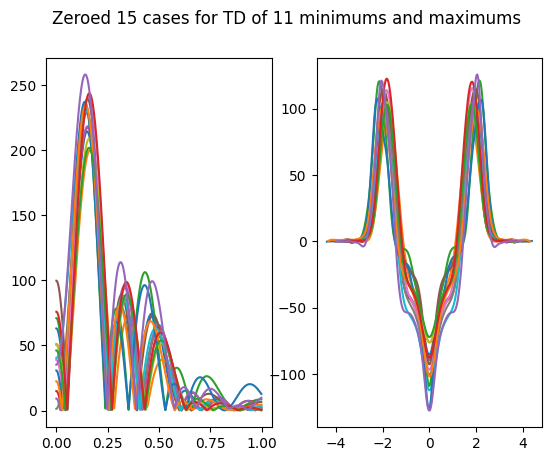

Indexes: [384, 162, 292, 229, 517, 199, 462, 241, 305, 306, 497, 86, 376, 313, 346]


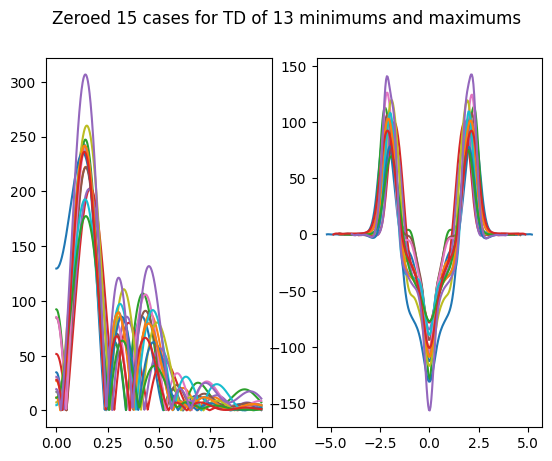

Indexes: [160, 265, 522, 586, 140, 397, 558, 489, 592, 442, 18, 339, 434, 602, 27]


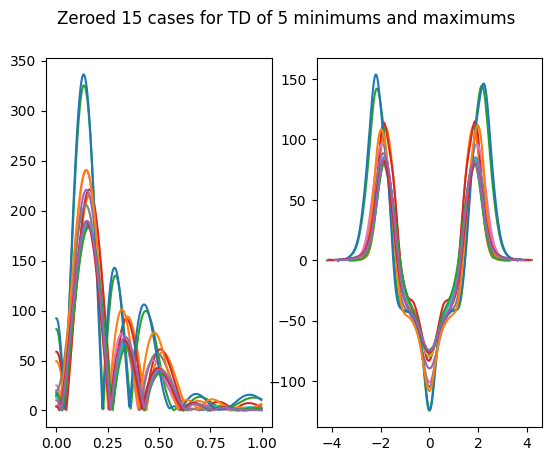

Indexes: [418, 281, 231, 330, 108, 109, 204, 529, 369, 372, 436, 534, 407, 601, 316]


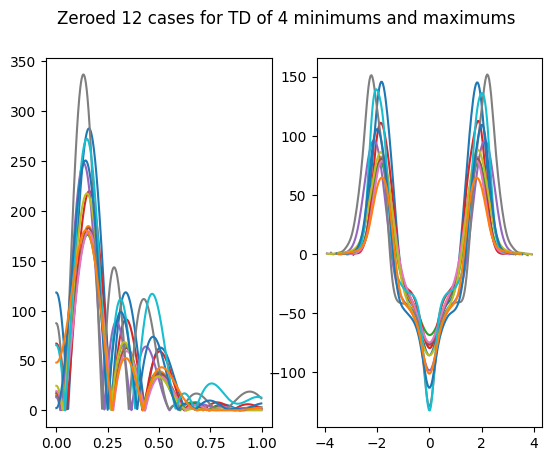

Indexes: [256, 129, 487, 12, 13, 110, 590, 302, 314, 251, 508, 510]


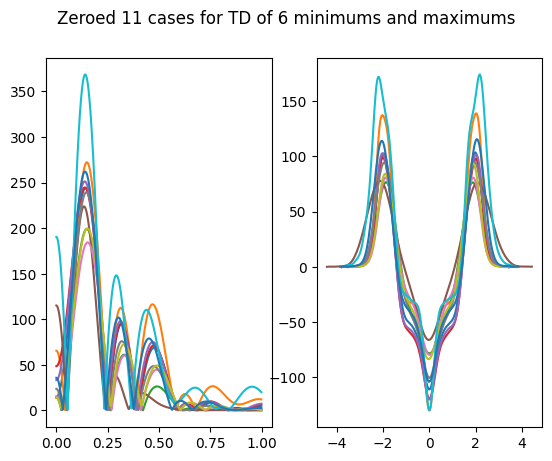

Indexes: [385, 550, 104, 200, 360, 459, 236, 371, 468, 247, 319]


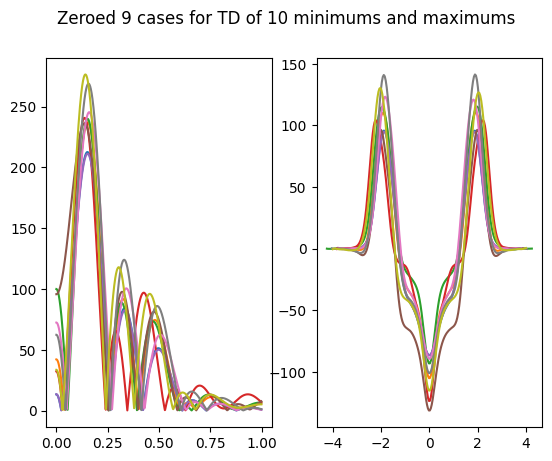

Indexes: [226, 293, 454, 299, 589, 301, 111, 19, 185]


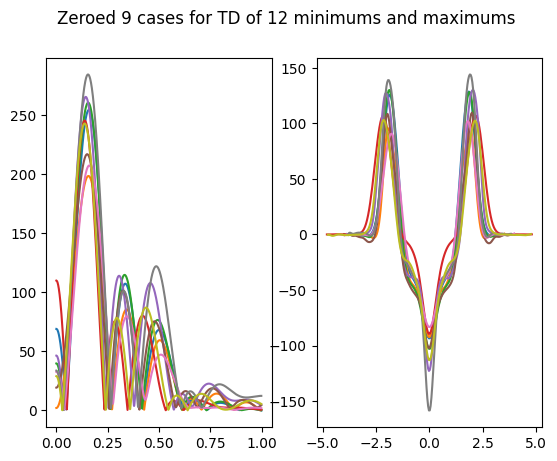

Indexes: [99, 415, 169, 555, 559, 147, 93, 478, 159]


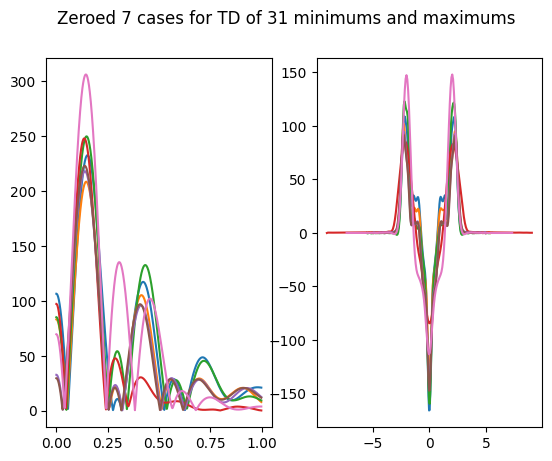

Indexes: [421, 423, 139, 45, 373, 438, 154]


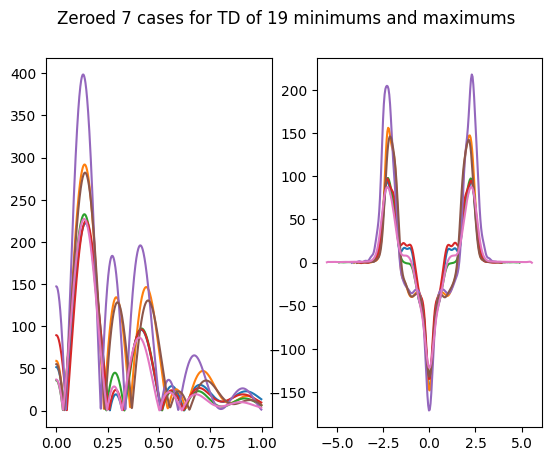

Indexes: [235, 48, 149, 507, 250, 59, 607]


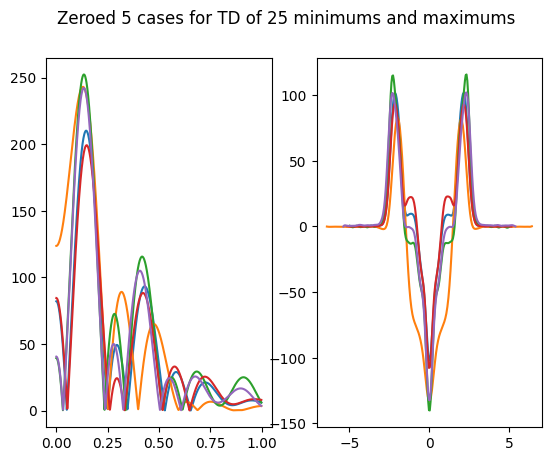

Indexes: [263, 523, 399, 469, 597]


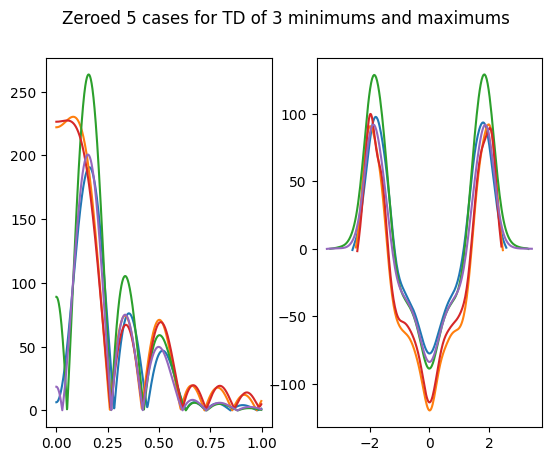

Indexes: [261, 10, 209, 118, 253]


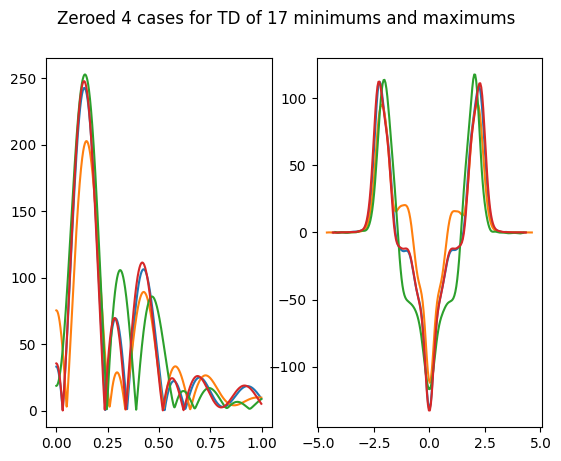

Indexes: [417, 119, 246, 55]


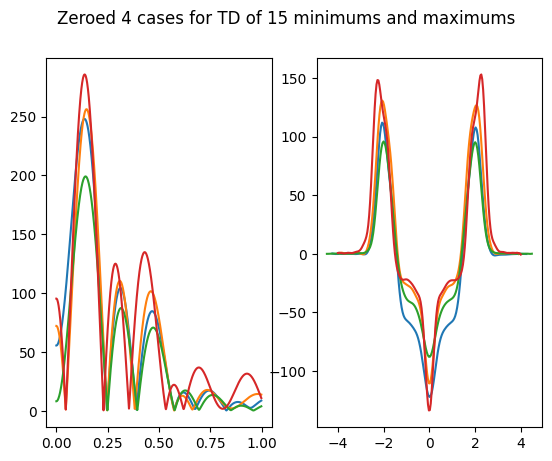

Indexes: [458, 381, 61, 350]


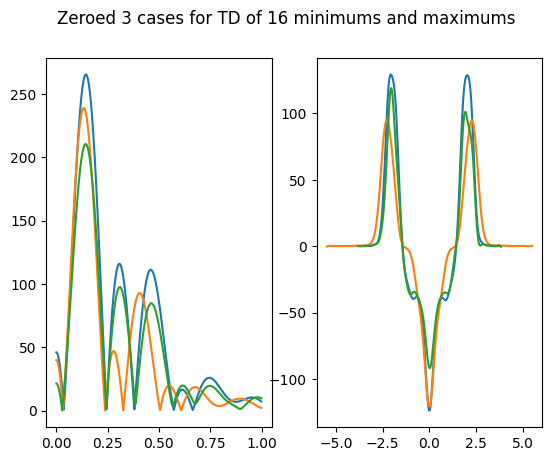

Indexes: [545, 514, 242]


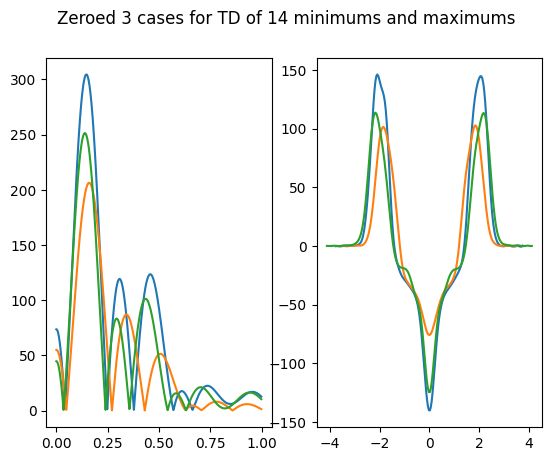

Indexes: [593, 505, 519]


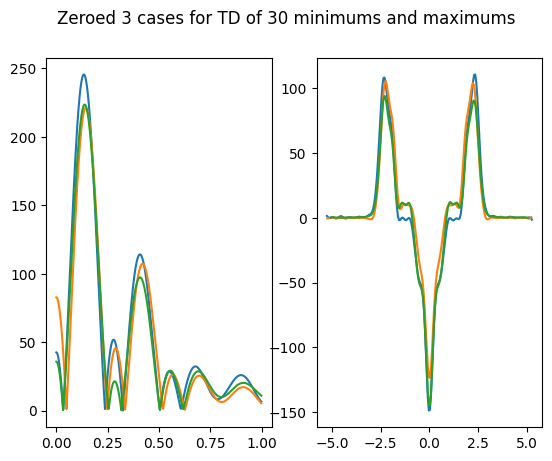

Indexes: [288, 51, 196]


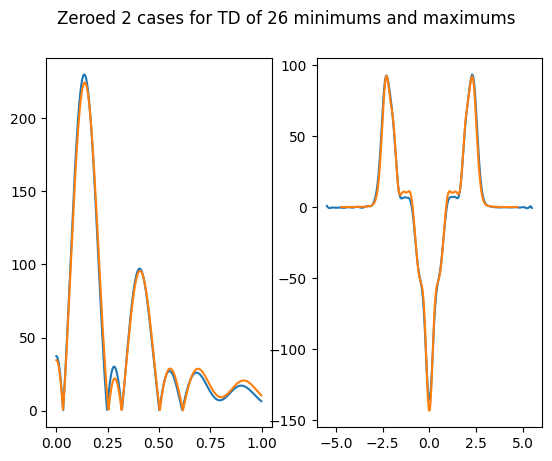

Indexes: [208, 46]


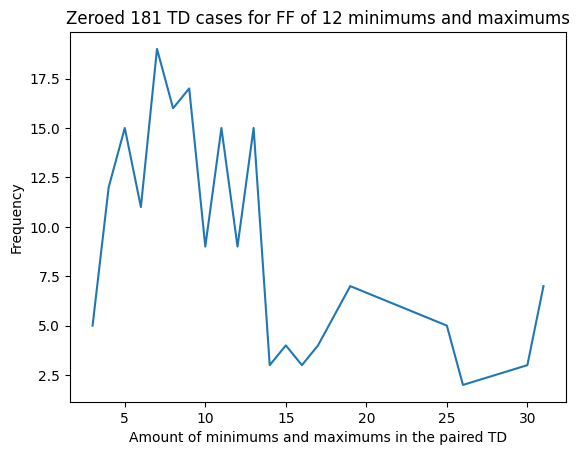


Plots of different TD peak cases for FF of 11 minimums and maximums
TD peak cases of min and max sums: [11, 7, 12, 10, 13, 3, 9, 5, 6, 14, 15, 8, 17, 4, 16, 20]
TD peak case freqs: [15.0, 11.0, 9.0, 8.0, 8.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0]


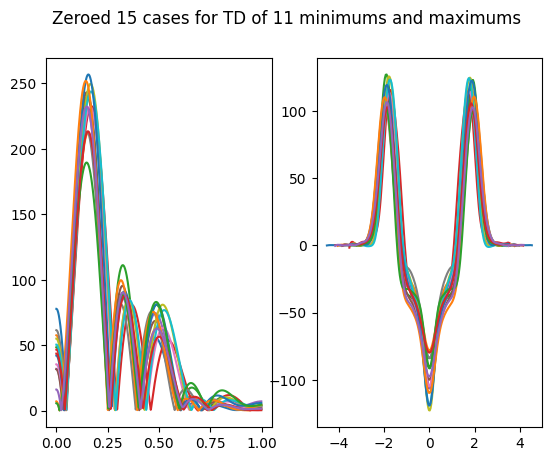

Indexes: [480, 66, 163, 612, 391, 553, 234, 460, 273, 212, 565, 599, 345, 283, 31]


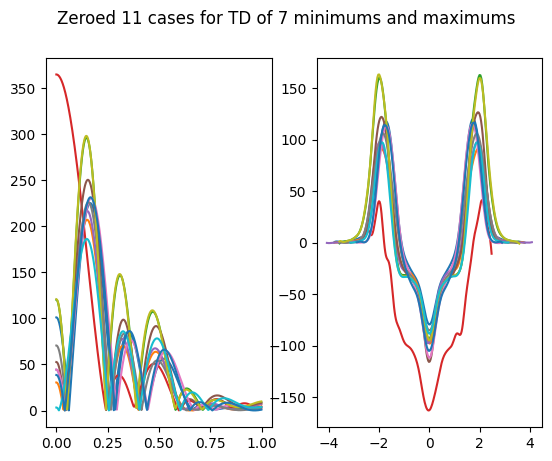

Indexes: [97, 258, 323, 419, 520, 14, 279, 216, 506, 443, 382]


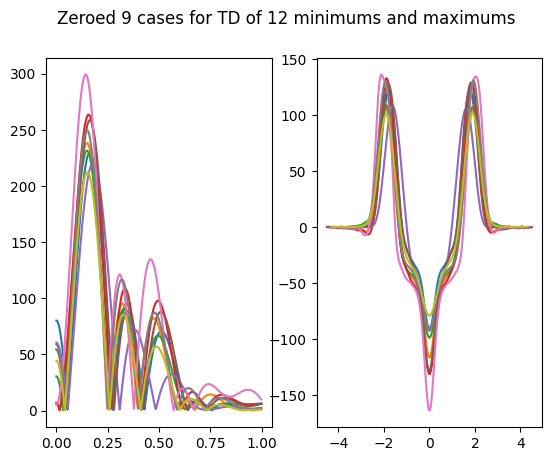

Indexes: [280, 194, 483, 238, 528, 336, 50, 276, 600]


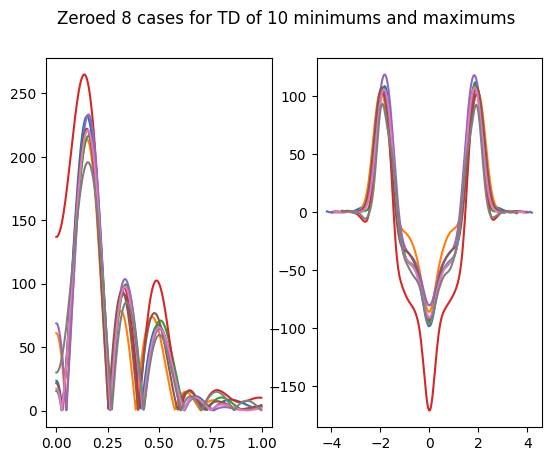

Indexes: [1, 165, 71, 298, 142, 340, 474, 573]


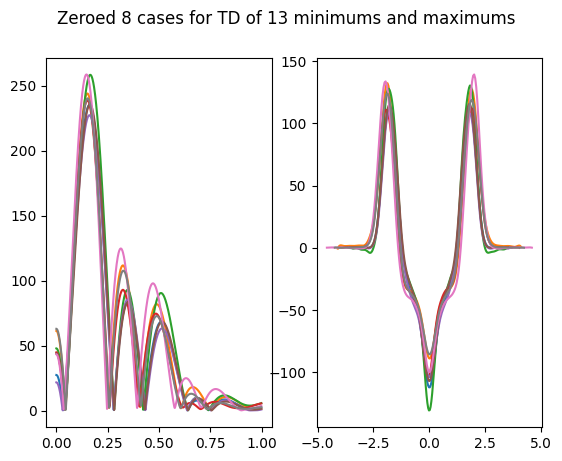

Indexes: [65, 164, 588, 525, 465, 211, 502, 156]


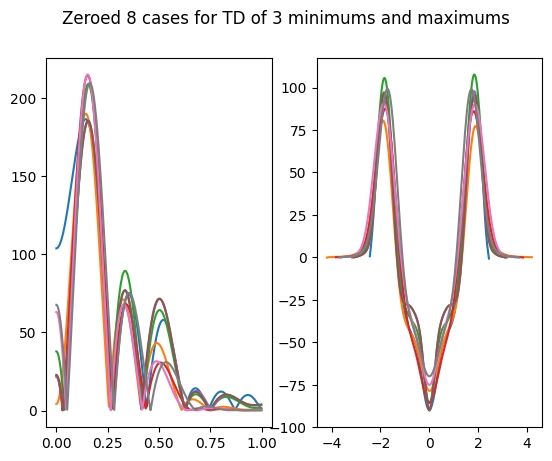

Indexes: [34, 396, 432, 594, 405, 406, 121, 60]


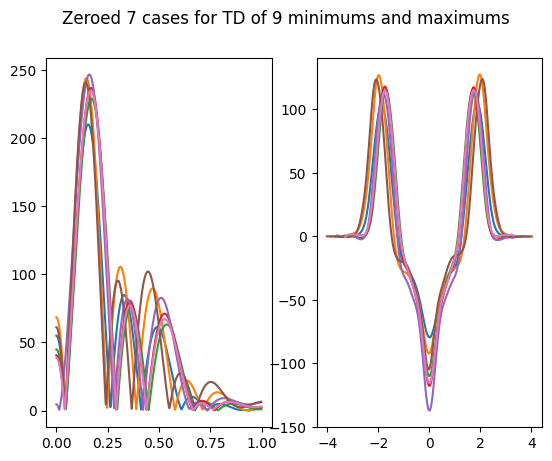

Indexes: [33, 327, 461, 370, 499, 412, 254]


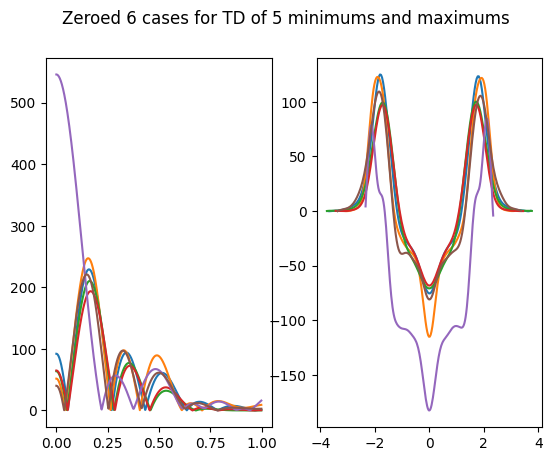

Indexes: [546, 197, 143, 83, 252, 188]


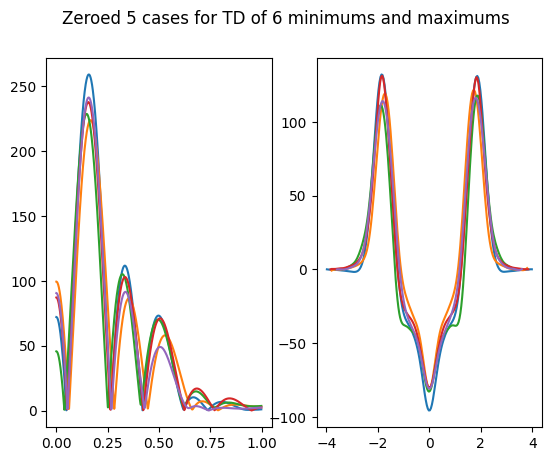

Indexes: [171, 269, 598, 408, 476]


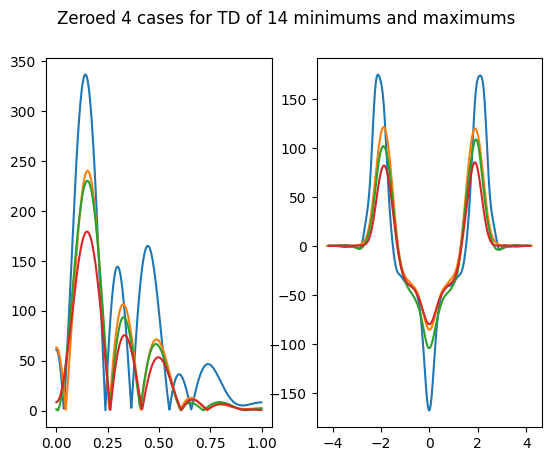

Indexes: [145, 155, 532, 95]


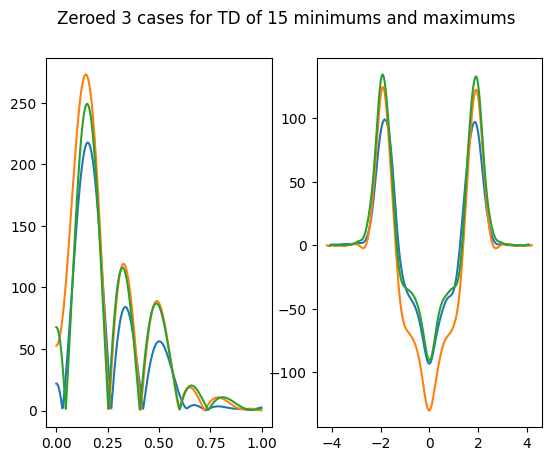

Indexes: [503, 518, 39]


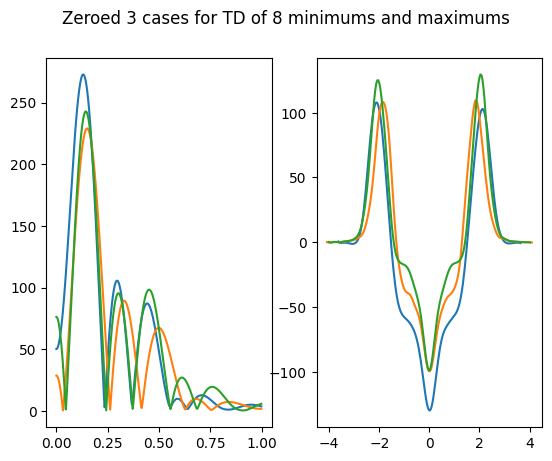

Indexes: [56, 233, 554]


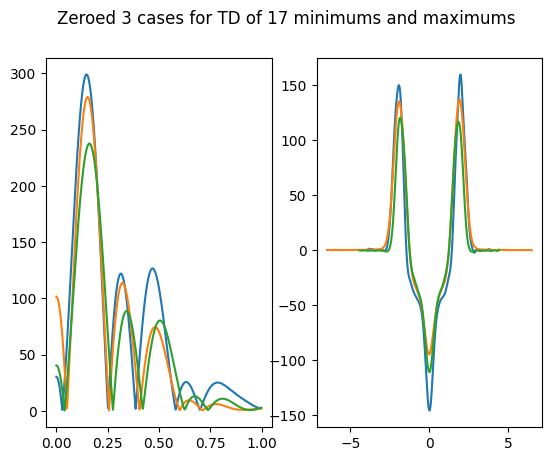

Indexes: [603, 404, 383]


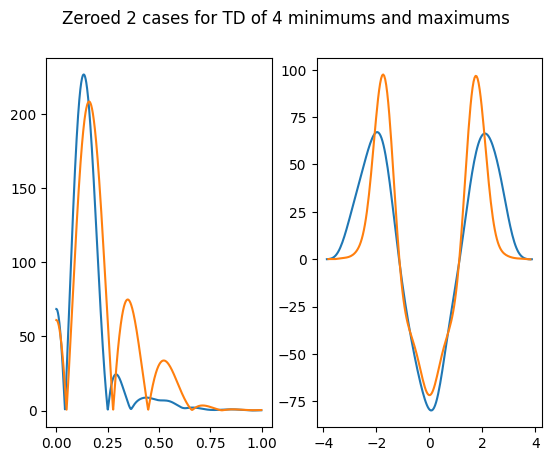

Indexes: [176, 410]


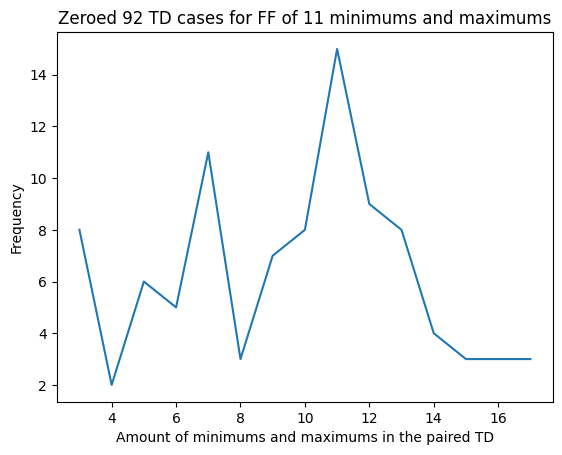


Plots of different TD peak cases for FF of 14 minimums and maximums
TD peak cases of min and max sums: [11, 10, 9, 8, 7, 31, 3, 5, 15, 6, 17, 18, 4, 16, 12, 19, 25]
TD peak case freqs: [6.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


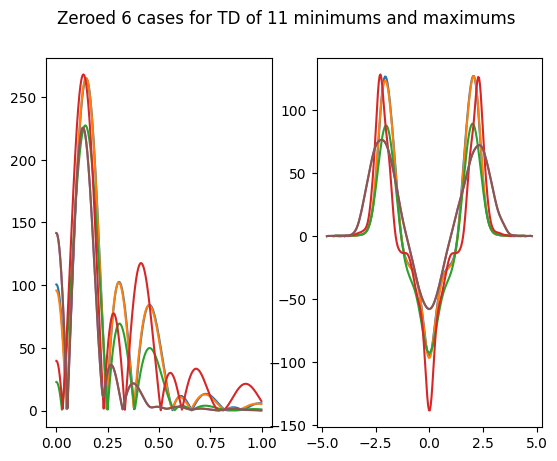

Indexes: [513, 198, 42, 400, 560, 561]


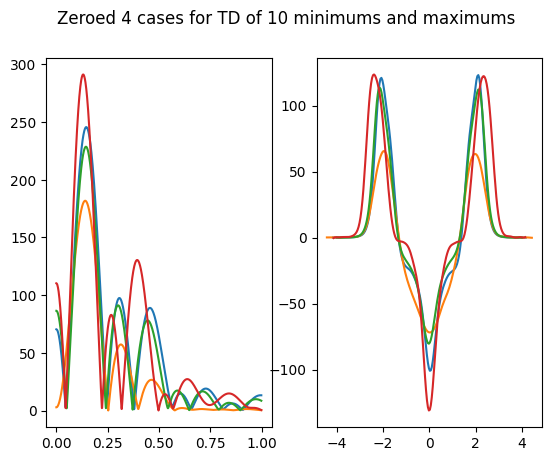

Indexes: [107, 521, 411, 126]


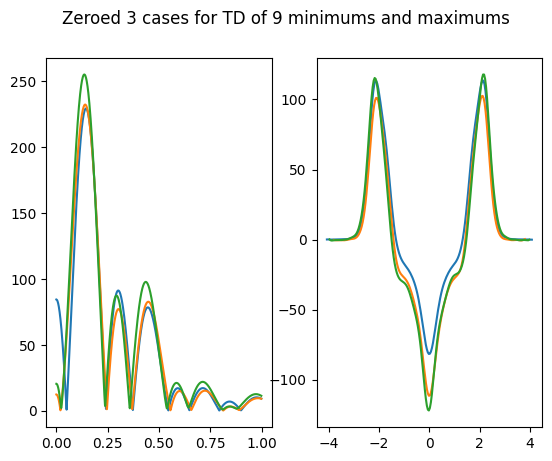

Indexes: [297, 451, 374]


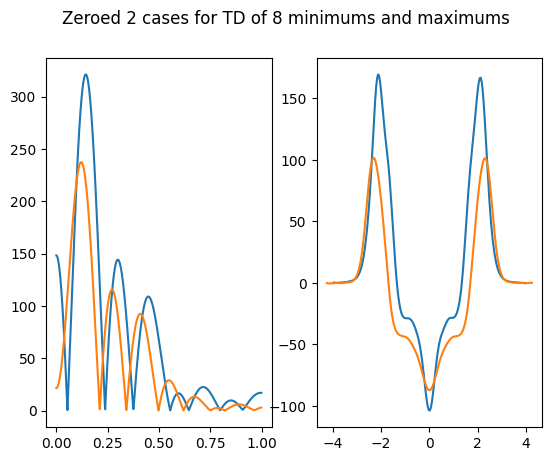

Indexes: [388, 566]


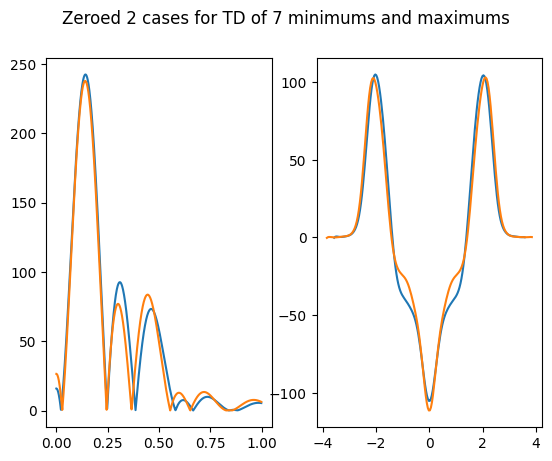

Indexes: [49, 4]


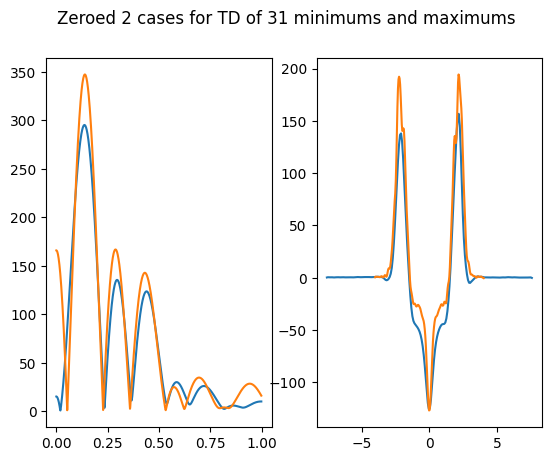

Indexes: [393, 333]


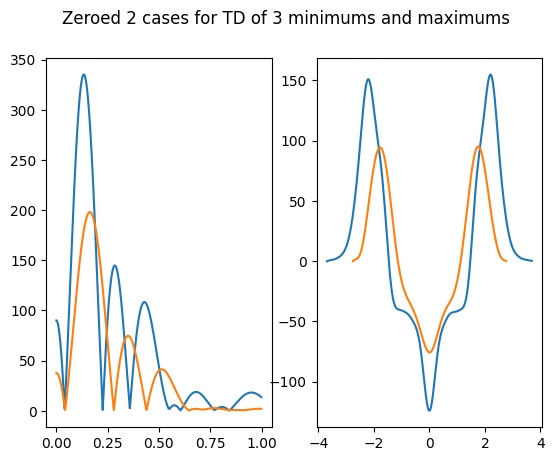

Indexes: [484, 223]


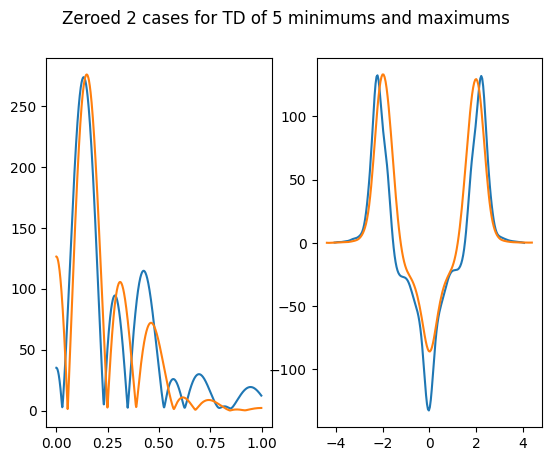

Indexes: [8, 130]


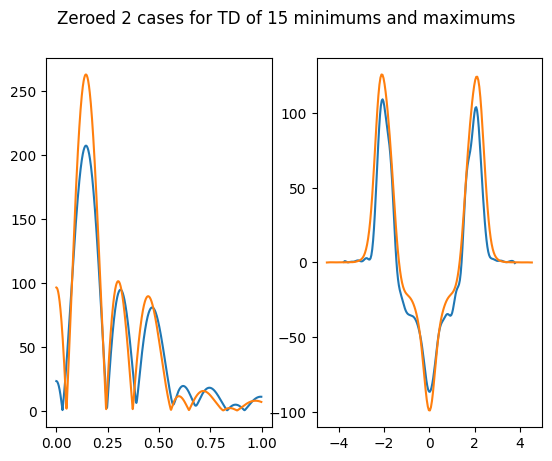

Indexes: [609, 77]


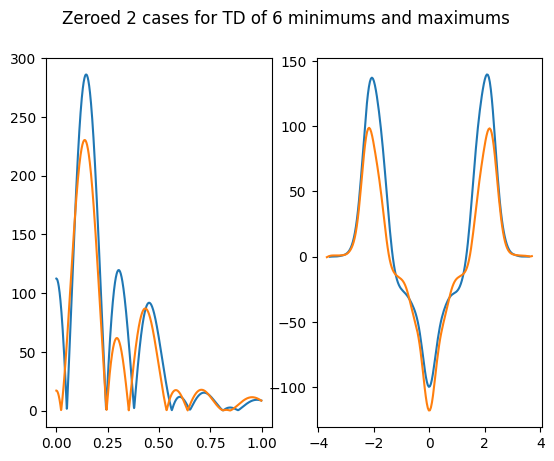

Indexes: [112, 180]


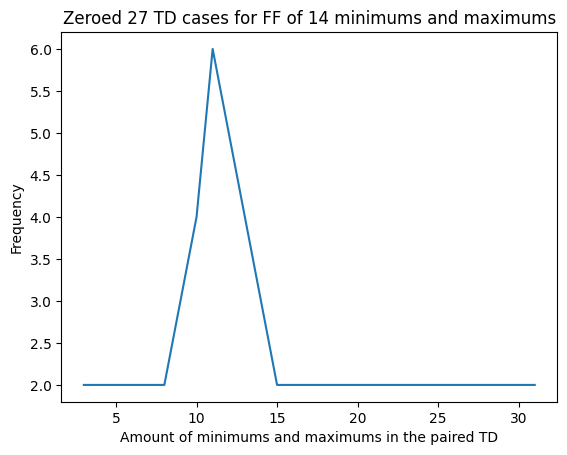


Plots of different TD peak cases for FF of 10 minimums and maximums
TD peak cases of min and max sums: [7, 3, 6, 8, 5, 4, 10, 12, 14, 15, 16, 13, 23, 11, 31]
TD peak case freqs: [4.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


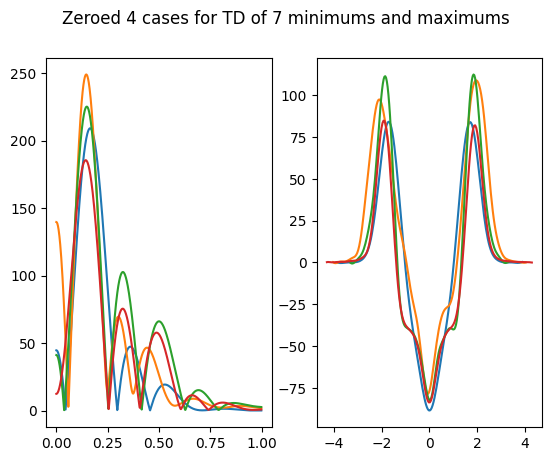

Indexes: [440, 57, 266, 334]


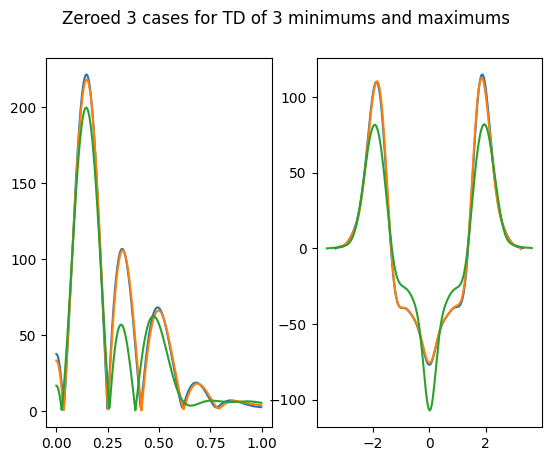

Indexes: [272, 570, 540]


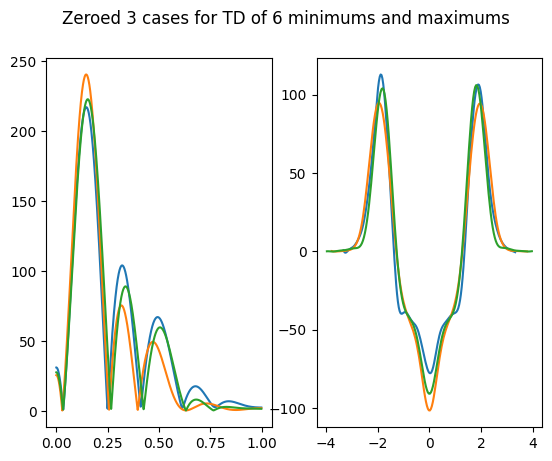

Indexes: [58, 582, 183]


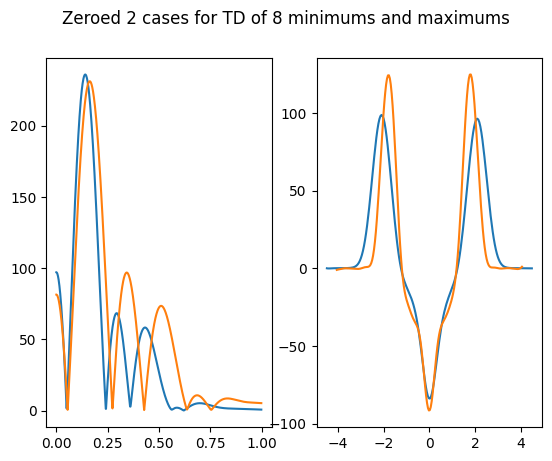

Indexes: [25, 131]


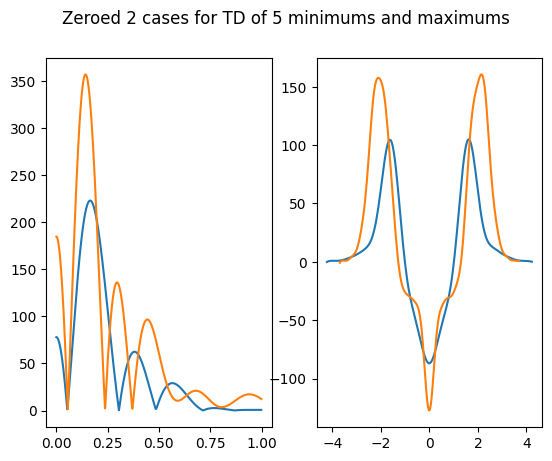

Indexes: [123, 541]


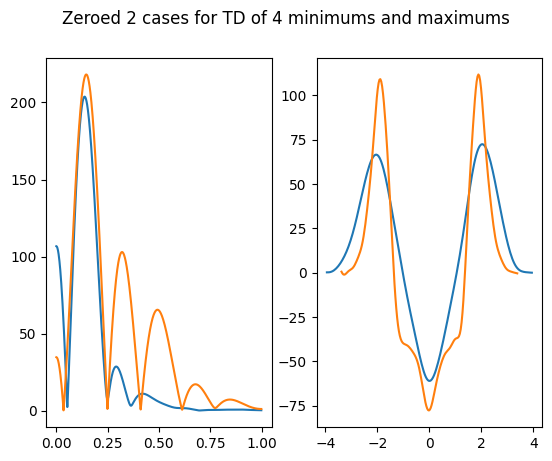

Indexes: [416, 492]


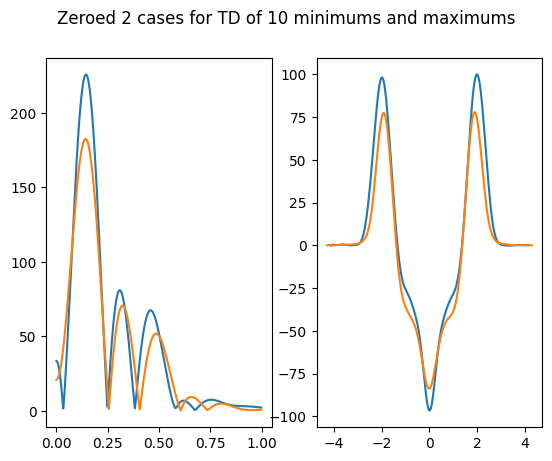

Indexes: [426, 375]


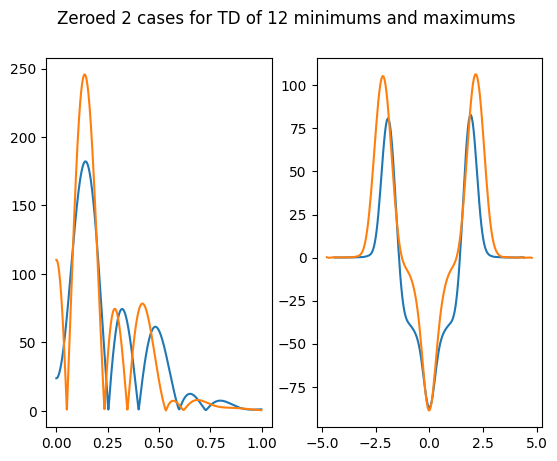

Indexes: [363, 556]


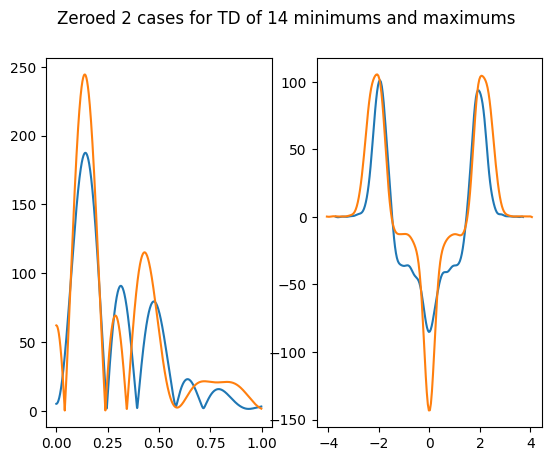

Indexes: [453, 606]


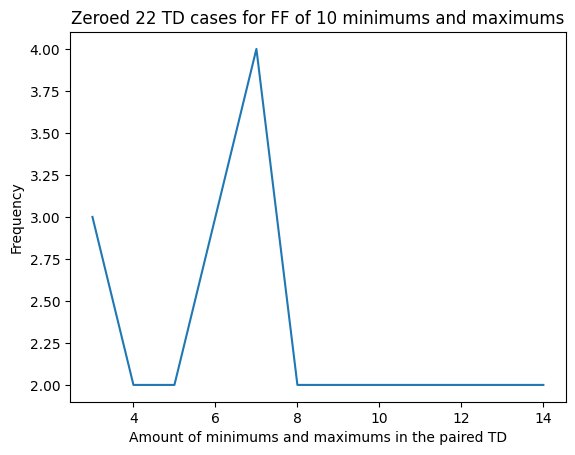

In [28]:
freq = Common_double_point_peak_FF.isna().sum(axis=0).value_counts().values
n_nans = Common_double_point_peak_FF.isna().sum(axis=0)

found_outliers = []

for n in Common_double_point_peak_FF.isna().sum(axis=0).value_counts().index:
    col_names = n_nans[n_nans == n].index
    names = set()
    for column in col_names:
        names.add(int(column[:-1]))

    names = list(names)

    peak_FF_df = Common_peak_FF_df[names]
    peak_TD_x_df = Common_peak_TD_x_df[names]
    peak_TD_y_df = Common_peak_TD_y_df[names]

    outlier_column_indexes = set([])

    for column in peak_TD_y_df.columns:
        if peak_TD_y_df[column][99] > -1:
            outlier_column_indexes.add(column)
            found_outliers.append(column)

    if len(outlier_column_indexes) > 0:
        peak_FF_df = peak_FF_df.drop(outlier_column_indexes, axis=1)
        peak_TD_x_df = peak_TD_x_df.drop(outlier_column_indexes, axis=1)
        peak_TD_y_df = peak_TD_y_df.drop(outlier_column_indexes, axis=1)

    peak_TD_columns = []
    for index in peak_TD_y_df.columns:
        peak_TD_columns.append(str(index) + 'i')
        peak_TD_columns.append(str(index) + 'v')

    temp_TD_peak = pd.DataFrame(index=range(31), columns=peak_TD_columns)

    longest_case = 0
    for index in peak_TD_y_df.columns:
        max_peaks_TD, _ = find_peaks(peak_TD_y_df[index])
        min_peaks_TD, _ = find_peaks(-peak_TD_y_df[index])

        TD_peak_index = np.hstack((max_peaks_TD, min_peaks_TD))
        TD_peak_index.sort()
        TD_peak_value = peak_TD_y_df[index][TD_peak_index]

        temp_TD_peak[str(index) + 'i'] = pd.Series(TD_peak_index)
        temp_TD_peak[str(index) + 'v'] = pd.Series(TD_peak_value.values)
        
    print('Plots of different TD peak cases for FF of ' + str(23-n) + ' minimums and maximums')
    print('TD peak cases of min and max sums: ' + str([31-i for i in temp_TD_peak.isna().sum(axis=0).value_counts().index]))
    print('TD peak case freqs: ' + str([i/2 for i in temp_TD_peak.isna().sum(axis=0).value_counts().values]))
    temp_freq = temp_TD_peak.isna().sum(axis=0).value_counts().values
    temp_n_nans = temp_TD_peak.isna().sum(axis=0)
    j = 0
    length_list = []
    freq_list = []
    #peak_outliers = []
    for temp_nan in temp_TD_peak.isna().sum(axis=0).value_counts().index:
        if temp_freq[j]/2 < 2:
            #peak_outliers.append(31-temp_nan)  
            continue

        length_list.append(31-temp_nan)
        freq_list.append(temp_freq[j]/2)
        temp_cols = temp_n_nans[temp_n_nans == temp_nan].index  

        second_names = set()
        for index in temp_cols:
            second_names.add(int(index[:-1]))

        second_names = list(second_names)
        
        for index in second_names:
            plt.subplot(1, 2, 1)
            plt.plot([round(i * 0.001,4) for i in range(0, 1000,1)], peak_FF_df[index])
            plt.subplot(1, 2, 2)
            plt.plot(peak_TD_x_df[index],peak_TD_y_df[index])
        
        plt.suptitle('Zeroed ' + str(len(second_names)) + ' cases for TD of ' + str(31-temp_nan) + ' minimums and maximums')
        plt.show()
        print('Indexes: ' + str(second_names))
        j = j + 1

    length_list, freq_list= zip(*sorted(zip(length_list, freq_list)))    
    
    if len(length_list) > 1:
        plt.plot(length_list,freq_list)
        plt.xlabel('Amount of minimums and maximums in the paired TD')
        plt.ylabel('Frequency')
        #plt.xscale('log')
        #plt.yscale('log')
        plt.title('Zeroed ' + str(int(sum(freq_list))) + ' TD cases for FF of ' + str(23-n) + ' minimums and maximums')
        plt.show()
        
    print('')